In [1]:
import pandas as pd
import numpy as np

import sys

import configparser

import geopandas as gpd
import shapely


from fluxdataqaqc import Data, QaQc, Plot

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
#sys.path.append("//")
sys.path.append("../../../micromet")
import micromet
from micromet import AmerifluxDataProcessor
%matplotlib inline

In [7]:
from pyproj import Transformer
EPSG = 5070
# load initial flux data
station = 'US-UTW'
config_path = f'../../station_config/{station}.ini'
config = configparser.ConfigParser()
config.read(config_path)

#station = 'US-UTW'
stat_configs = micromet.load_configs(station,
                                     config_path='../../station_config/',
                                     secrets_path="../../secrets/config.ini")

df = micromet.fetch_and_preprocess_data(stat_configs['url'], station, startdate='2022-01-01',)

d = Data(config_path)
d.df.index.freq = '30min'
df = d.df.rename(columns=d.inv_map)
q = QaQc(d, daily_frac=3/4, max_interp_hours=4, max_interp_hours_night=6)

# make copies of daily results of different correction options
q.correct_data(meth='ebr', et_gap_fill=True)
ebr_gapfilled = q.df


latitude = config['METADATA']['station_latitude']
longitude = config['METADATA']['station_longitude']

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")

Calculating mean for var: THETA from columns: ['SWC_1_1_1', 'SWC_2_1_1']
Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure

The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 4 hours when Rn >= 0.


c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Filtering days with less then 75.0% or 36/48 sub-daily measurements
gridMET reference ET already downloaded for station at:
C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\Notebooks\Footprints\..\..\station_config\gridMET_data\US-UTW_39.4417N_-110.7250W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)
Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=-1251001.1681334283, Y=1921955.9906738813


In [30]:
data = pd.read_csv(config['METADATA']['climate_file_path'],
                   skiprows=int(config['METADATA']['skiprows']))
data['datetime_start'] = pd.to_datetime(data['datetime_start'])
data = data[(data['datetime_start'].dt.hour >= 6)&(data['datetime_start'].dt.hour <= 18)]

In [31]:
foot_xy = {}


#df = pd.read_csv("../../station_data/US-CdM_HH_202306141100_202410081700.csv")
for col in data.columns:
    if "fetch" in col.lower():
        data = micromet.polar_to_cartesian_dataframe(data, wd_column='WD',dist_column=col)

        data[f'X_{col}'] = data[f'X_{col}'] + station_x
        data[f'Y_{col}'] = data[f'Y_{col}'] + station_y

        foot_xy[col] = micromet.aggregate_to_daily_centroid(data,'datetime_start',f'X_{col}',f'Y_{col}',weighted=True)

daily_pnts = foot_xy['FETCH_55']
daily_pnts['geometry'] = gpd.points_from_xy(daily_pnts['X_FETCH_55'],
                                      daily_pnts['Y_FETCH_55'])
daily_pnts['date'] = pd.to_datetime(daily_pnts['Date'])
daily_pnts.drop(columns='Date', inplace=True)
daily_pnts.set_index('date', inplace=True)
daily_pnts = pd.concat([ebr_gapfilled, daily_pnts], axis=1)
daily_pnts_geo = gpd.GeoDataFrame(daily_pnts, geometry=daily_pnts.geometry)

data['ETpos'] = np.where(data['ET']>=0,data['ET'],np.nan)
#
data = data.set_index('datetime_start')

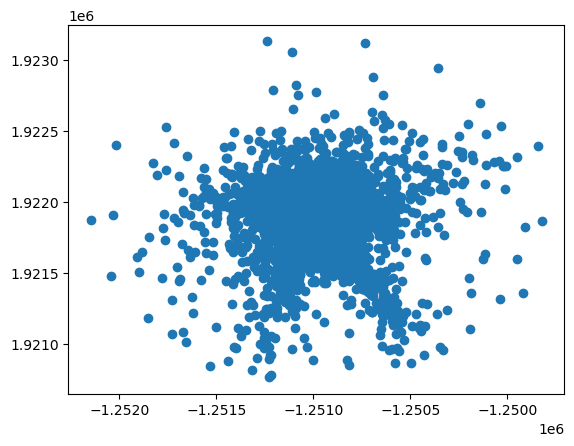

In [32]:
import matplotlib.pyplot as plt
plt.scatter(data['X_FETCH_55'],data['Y_FETCH_55'])

In [35]:
def plot_density_raster(density, transform, gdf, show_points=True):
    """
    Plots the density raster and overlays the input points.

    Parameters:
        density (numpy.ndarray): The rasterized density grid.
        transform (Affine): Raster transform for correct alignment.
        gdf (GeoDataFrame): The original point data to overlay.
    """

    # Get raster bounds
    xmin, ymax = transform.c, transform.f  # Top-left corner
    res = transform.a  # Cell size
    xmax = xmin + (density.shape[1] * res)
    ymin = ymax - (density.shape[0] * res)

    # Create the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the density raster
    extent = [xmin, xmax, ymin, ymax]  # (left, right, bottom, top)
    im = ax.imshow(density, extent=extent, origin="upper", cmap="viridis", alpha=0.7)

    if show_points:
        # Overlay the input points
        gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, edgecolor="black")

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, label="Normalized Density")
    ax.set_title("Density Raster")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

    return fig, ax

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point



def concat_fetch_gdf(data, epsg=5070):
    dataxy = data.dropna(subset=['X_FETCH_90',
                               'Y_FETCH_90',
                               'X_FETCH_55',
                               'Y_FETCH_55',
                               'X_FETCH_40',
                               'Y_FETCH_40'],
                       how='any')

    dates = np.concatenate((dataxy.index.values, dataxy.index.values, dataxy.index.values))

    xs = np.concatenate((dataxy['X_FETCH_90'].values, dataxy['X_FETCH_55'].values, dataxy['X_FETCH_40'].values))
    ys = np.concatenate((dataxy['Y_FETCH_90'].values,  dataxy['Y_FETCH_55'].values,  dataxy['Y_FETCH_40'].values))

    weights = np.concatenate(([90]*len(dataxy['X_FETCH_90']),
                        [55]*len(dataxy['X_FETCH_55']),
                        [40]*len(dataxy['X_FETCH_40'])))

    # Create a DataFrame
    df = pd.DataFrame({'datetime_start':dates,
                       'x': xs,
                       'y': ys,
                       'weights': weights,
                       })

    df = df.set_index('datetime_start')

    dfday = df.groupby(pd.Grouper(freq='1D')).apply(
                    lambda g: pd.Series(
                        {
                            'x': (g['x'] * g["weights"]).sum() / g["weights"].sum(),
                            'y': (g['y'] * g["weights"]).sum() / g["weights"].sum(),
                            'weights': g['weights'].mean(),
                        }
                    )
                )

    # Convert to GeoDataFrame
    gdf_day = gpd.GeoDataFrame(dfday, geometry=[Point(xy) for xy in zip(dfday.x, dfday.y)])

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.x, df.y)])

    # Optionally set a CRS (e.g., WGS84)
    gdf_day = gdf_day.set_crs(epsg=epsg)
    gdf_day = gdf_day.dropna()

    gdf = gdf.set_crs(epsg=epsg)
    gdf = gdf.dropna()

    return gdf_day, gdf

In [16]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr
import rasterio.crs

epsg = 5070

gdf_day, gdf = concat_fetch_gdf(data,epsg=epsg)

res = 100

# List to hold KDE results for each day
kde_results = []

xmin = gdf.x.min()
xmax = gdf.x.max()
ymin = gdf.y.min()
ymax = gdf.y.max()

# Step 1: Create 2D grid
xvals = np.linspace(xmin, xmax, res)  # X range
yvals = np.linspace(ymin, ymax, res)  # Y range

X, Y = np.meshgrid(xvals, yvals)
positions = np.vstack([X.ravel(), Y.ravel()])

for day in gdf_day.index.date:
    hf_hr = gdf[gdf.index.date == day]
    m1 = hf_hr['x']
    m2 = hf_hr['y']

    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values, weights=hf_hr['weights'])
    Z = np.reshape(kernel(positions).T, X.shape)

    # Step 3: Compute 90th percentile threshold
    threshold_90 = np.percentile(Z, 90)

    # Step 4: Apply mask (set values > 90th percentile to NaN)
    Z_masked = np.where(Z > threshold_90, Z, np.nan)

    # Step 5: Normalize the masked values
    valid_sum = np.nansum(Z_masked)  # Sum only valid (non-NaN) values
    if valid_sum > 0:
        Z_normalized = Z_masked / valid_sum  # Normalize
    else:
        Z_normalized = Z_masked  # Avoid division by zero

    # Step 6: Create an xarray DataArray with georeferencing
    kde_da = xr.DataArray(
        Z_masked[:, :, np.newaxis],
        coords={'X': xvals,
                'Y': yvals,
                'time': [day],
                },  # Adjust for your coordinate system
        dims=['Y', 'X', 'time'],
        name='KDE',
    )

    # Optional: Assign CRS (WGS 84 for example)

    kde_da.attrs['crs'] = rasterio.crs.CRS.from_epsg(epsg)

    # Append the result to the list
    kde_results.append(kde_da)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_17152\4034255750.py:37: RuntimeWarning: invalid value encountered in scalar divide
  'x': (g['x'] * g["weights"]).sum() / g["weights"].sum(),
C:\Users\paulinkenbrandt\AppData\Local\Temp\ipykernel_17152\4034255750.py:38: RuntimeWarning: invalid value encountered in scalar divide
  'y': (g['y'] * g["weights"]).sum() / g["weights"].sum(),


<xarray.DataArray 'KDE' (Y: 100, X: 100, time: 1159)> Size: 93MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan,

In [ ]:
import datetime
kde_da_all.sel(time=datetime.date(2021, 8, 30)).plot()

In [17]:
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde

# Example: List of dates (could be strings or datetime objects)
dates = ['2025-02-01', '2025-02-02', '2025-02-03']

# Example: Generate some random data points for each day (replace with actual data)
# For simplicity, we'll use random data; in your case, you would load the actual points for each day.
data_per_day = [np.random.randn(2, 1000) for _ in dates]

# Example grid for KDE (same grid for each day)
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
grid_x, grid_y = np.meshgrid(x, y)

# List to hold KDE results for each day
kde_results = []

# Loop over each day's data
for day, data in zip(dates, data_per_day):
    # Fit the KDE to the data for the day
    kde = gaussian_kde(data)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()])
    kde_values = kde(grid_points).reshape(grid_x.shape)

    # Create a DataArray for the day and add it to the list
    kde_da_day = xr.DataArray(
        kde_values,
        coords=[('latitude', y), ('longitude', x), ],
        dims=['latitude', 'longitude'],
        name='KDE',
        attrs={'time': day}  # Add the time (or date) as an attribute
    )

    # Append the result to the list
    kde_results.append(kde_da_day)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


<xarray.DataArray 'KDE' (time: 3, latitude: 100, longitude: 100)> Size: 240kB
array([[[9.82611118e-228, 4.10494771e-221, 1.13158036e-214, ...,
         2.30854250e-225, 5.55272632e-232, 8.81305501e-239],
        [2.97187581e-222, 1.24655174e-215, 3.45018018e-209, ...,
         1.24055741e-219, 2.99598033e-226, 4.77433475e-233],
        [6.23125691e-217, 2.62427295e-210, 7.29279774e-204, ...,
         4.62159492e-214, 1.12064398e-220, 1.79306184e-227],
        ...,
        [1.03450891e-263, 2.26790598e-257, 3.30727179e-251, ...,
         2.67410392e-241, 1.62144986e-248, 6.48781020e-256],
        [1.15839263e-270, 2.56223389e-264, 3.77835065e-258, ...,
         7.22559438e-247, 4.39882951e-254, 1.76710068e-261],
        [9.01890909e-278, 2.01548782e-271, 3.01099317e-265, ...,
         1.35356822e-252, 8.27350264e-260, 3.33699661e-267]],

       [[5.76417328e-254, 1.06739220e-247, 1.30252842e-241, ...,
         2.05775415e-264, 2.12361899e-271, 1.44422847e-278],
        [4.58576184e-247,

<Axes: >

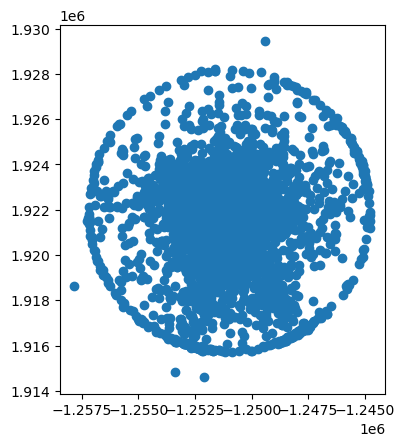

In [18]:
gdf.dropna().plot()#.plot()

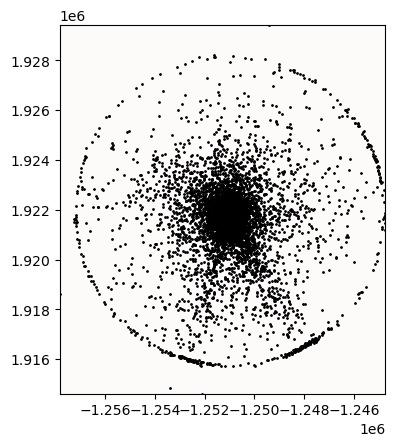

In [20]:


m1 = gdf['x']
m2 = gdf['y']

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)


fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

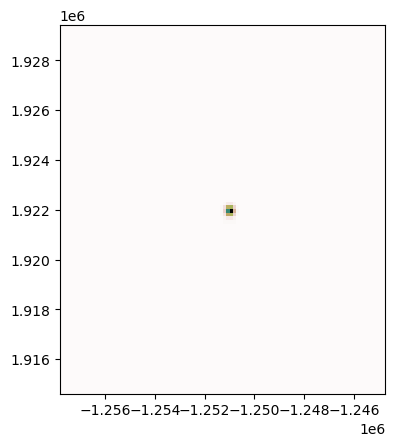

In [21]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


In [22]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

data = data.dropna(subset=['X_FETCH_90',
                           'Y_FETCH_90',
                           'X_FETCH_55',
                           'Y_FETCH_55',
                           'X_FETCH_40',
                           'Y_FETCH_40'],
                   how='any')

xs = np.concatenate((data['X_FETCH_90'].values, data['X_FETCH_55'].values, data['X_FETCH_40'].values))
ys = np.concatenate((data['Y_FETCH_90'].values,  data['Y_FETCH_55'].values,  data['Y_FETCH_40'].values))
weights = np.concatenate(([90]*len(data['X_FETCH_90']),
                    [55]*len(data['X_FETCH_55']),
                    [40]*len(data['X_FETCH_40'])))


#buffer_distance = 0
resolution = 50

# Define raster extent with buffer
xmin = np.min(xs)
ymin = np.min(ys)
xmax = np.max(xs)
ymax = np.max(ys)

# Create a mesh grid
xgrid = np.arange(xmin, xmax, resolution)
ygrid = np.arange(ymin, ymax, resolution)
xmesh, ymesh = np.meshgrid(xgrid, ygrid)

# Perform KDE with weights
kde = gaussian_kde(np.vstack([xs, ys]), weights=weights)
density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

# Normalize to ensure sum of cell values is 1
#print(np.sum(density))
#density /= np.sum(density)

# Define raster transform
transform = from_origin(xmin, ymax, resolution, resolution)

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [ ]:
xmin

In [23]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

densitynorm = density / np.sum(density)

# Get raster bounds
xmin, ymax = transform.c, transform.f  # Top-left corner
res = transform.a  # Cell size
xmax = xmin + (density.shape[1] * res)
ymin = ymax - (density.shape[0] * res)

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the density raster
extent = [xmin, xmax, ymin, ymax]  # (left, right, bottom, top)
im = ax.imshow(densitynorm, extent=extent, origin="upper", cmap="viridis", alpha=0.7)
data_geo.plot(ax=ax, color="red", markersize=10, alpha=0.3, edgecolor="black")
print(extent)

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, label="Normalized Density")
ax.set_title("Density Raster")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


ax.scatter(station_x, station_y,color='red')
plt.xlim(xmin+5500, xmax-5500)
plt.ylim(ymin+6500, ymax-6500)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
import pandas as pd
import numpy as np

def impute_evapotranspiration(df, in_field='ET', out_field='ET'):
    """
    Impute missing data in a half-hourly evapotranspiration time series.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a column 'ET' containing evapotranspiration data.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Step 1: Linear interpolation for small gaps
    df[out_field] = df[in_field].interpolate(method='linear', limit=4)  # Limit to prevent long-term bias

    # Step 2: Seasonal and daily imputation
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['day_of_year'] = df.index.dayofyear

    # Compute typical ET values at the same time across different years
    daily_medians = df.groupby(['day_of_year', 'hour', 'minute'])[out_field].median()

    # Impute missing values using seasonal daily median
    def impute_from_medians(row):
        if pd.isna(row[out_field]):
            return daily_medians.get((row['day_of_year'], row['hour'], row['minute']), np.nan)
        return row[out_field]

    df[out_field] = df.apply(impute_from_medians, axis=1)

    # Step 3: Rolling mean smoothing to refine imputations
    df[out_field] = df[out_field].bfill().ffill()  # Handle any remaining NaNs
    df[out_field] = df[out_field].rolling(window=6, min_periods=1, center=True).mean()  # Smooth over 3 hours

    # Drop helper columns
    df.drop(columns=['hour', 'minute', 'day_of_year'], inplace=True)

    return df

# Example usage:
# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
# df = impute_evapotranspiration(df)

# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
# imputer = EvapotranspirationImputer(df)
# df_imputed = imputer.impute(method="seasonal_median")


<Axes: xlabel='datetime_start'>

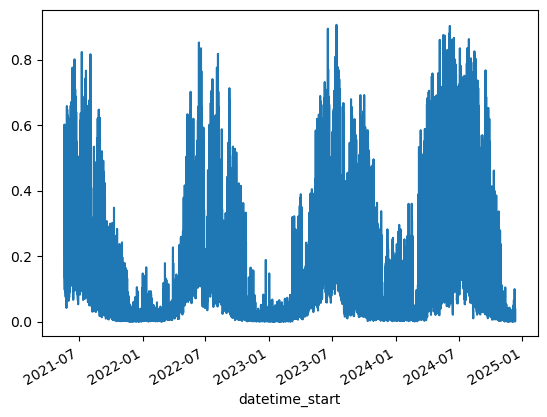

In [37]:
# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
data = impute_evapotranspiration(data,in_field='ETpos',out_field='ETimp')
#df_imputed = imputer.impute(method="seasonal_median")
data['ETimp'].plot()

In [39]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde


def generate_density_raster(
    gdf,
    resolution=50,  # Cell size in meters
    buffer_distance=200,  # Buffer beyond extent in meters
    epsg=5070,  # Default coordinate system
    weight_field="ET",
):
    """
    Generate a density raster from a point GeoDataFrame, weighted by the ET field.

    Parameters:
        gdf (GeoDataFrame): Input point GeoDataFrame with an 'ET' field.
        resolution (float): Raster cell size in meters (default: 50m).
        buffer_distance (float): Buffer beyond point extent (default: 200m).
        epsg (int): Coordinate system EPSG code (default: 5070).
        weight_field (str): Weight field name (default: ET).

    Returns:
        raster (numpy.ndarray): Normalized density raster.
        transform (Affine): Affine transformation for georeferencing.
        bounds (tuple): (xmin, ymin, xmax, ymax) of the raster extent.
    """

    # Ensure correct CRS
    gdf = gdf.to_crs(epsg=epsg)

    # Extract point coordinates and ET values
    x = gdf.geometry.x
    y = gdf.geometry.y
    weights = gdf[weight_field].values

    # Define raster extent with buffer
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, xmax = xmin - buffer_distance, xmax + buffer_distance
    ymin, ymax = ymin - buffer_distance, ymax + buffer_distance

    # Create a mesh grid
    xgrid = np.arange(xmin, xmax, resolution)
    ygrid = np.arange(ymin, ymax, resolution)
    xmesh, ymesh = np.meshgrid(xgrid, ygrid)

    # Perform KDE with weights
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)
    density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

    # Normalize to ensure sum of cell values is 1
    print(np.sum(density))
    density /= np.sum(density)

    # Define raster transform
    transform = from_origin(xmin, ymax, resolution, resolution)

    return density, transform, (xmin, ymin, xmax, ymax)

In [40]:
from scipy.stats import gaussian_kde

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

density, transform, (xmin, ymin, xmax, ymax) = generate_density_raster(data_geo,
                                                                                resolution=10,
                                                                                buffer_distance=10,
                                                                                weight_field='ETimp')

0.009999970593756864


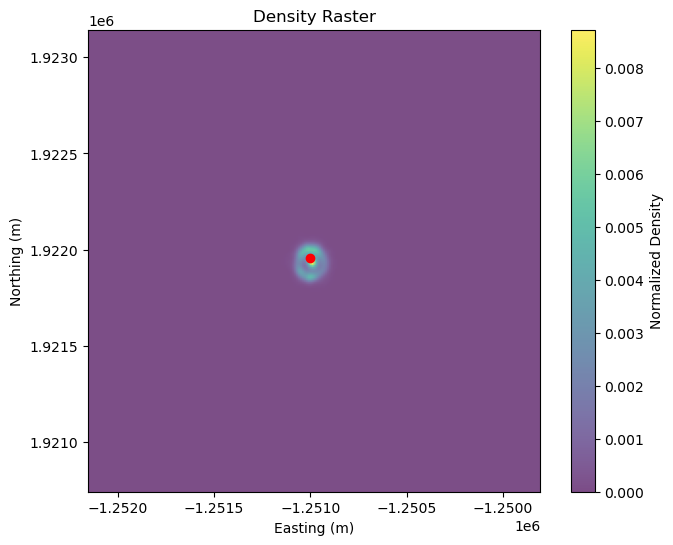

In [41]:
fig, ax = plot_density_raster(density,transform,data_geo,show_points=False)
ax.scatter(station_x, station_y,color='red')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(density)

In [ ]:
data_geo

In [ ]:
daily_pnts.dropna(subset=['X_FETCH_55', 'ET'], inplace=True)
daily_pnts

In [42]:
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)

for ind in daily_pnts.index:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)
    #(EPSG:5070)



-110.72861267348797 39.444757211053194
-110.72831791546206 39.44486285960151
-110.72847382753461 39.445060664294665
-110.72891994718208 39.44472090967058
-110.72917503946589 39.44534716597946
-110.72834889125609 39.44502060234712
-110.72923202680252 39.44497904333274
-95.99993054341543 22.999897414917605
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.00000000000001
-96.00000000000001 23.000000

In [43]:
import requests

keyconf_path = f'../../secrets/config.ini'
keyconf = configparser.ConfigParser()
keyconf.read(keyconf_path)

# set your API key before making the request
header = {"Authorization": keyconf['OPENET']['key']}

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)


oet = {}
i = 0
for ind in daily_pnts.index[:]:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)


    args = {
      "date_range": [
        f"{ind:%Y-%m-%d}",
        f"{ind+pd.Timedelta(days=1):%Y-%m-%d}"
      ],
      "file_format": "JSON",
      "geometry": [
        -121.36322,
        38.87626
      ],
      "interval": "daily",
      "model": "Ensemble",
      "reference_et": "gridMET",
      "units": "mm",
      "variable": "ET"
    }

    # query the api
    resp = requests.post(
        headers=header,
        json=args,
        url="https://openet-api.org/raster/timeseries/point"
    )

    if resp.status_code != 200:
        pass
    else:
        print(resp.json(),i)
        oet[ind] = resp.json()[0]['et']
    i+=1

-110.72861267348797 39.444757211053194
[{'time': '2021-05-20', 'et': 5.383}, {'time': '2021-05-21', 'et': 5.595}] 0
-110.72831791546206 39.44486285960151
[{'time': '2021-05-21', 'et': 5.595}, {'time': '2021-05-22', 'et': 5.107}] 1
-110.72847382753461 39.445060664294665
[{'time': '2021-05-22', 'et': 5.107}, {'time': '2021-05-23', 'et': 6.354}] 2
-110.72891994718208 39.44472090967058
[{'time': '2021-05-23', 'et': 6.354}, {'time': '2021-05-24', 'et': 7.059}] 3
-110.72917503946589 39.44534716597946
[{'time': '2021-05-24', 'et': 7.059}, {'time': '2021-05-25', 'et': 7.956}] 4
-110.72834889125609 39.44502060234712
[{'time': '2021-05-25', 'et': 7.956}, {'time': '2021-05-26', 'et': 8.726}] 5
-110.72923202680252 39.44497904333274
[{'time': '2021-05-26', 'et': 8.726}, {'time': '2021-05-27', 'et': 8.633}] 6
-95.99993054341543 22.999897414917605
[{'time': '2021-05-27', 'et': 8.633}, {'time': '2021-05-28', 'et': 7.397}] 7
-96.00000000000001 23.00000000000001
[{'time': '2021-05-28', 'et': 7.397}, {'t

In [44]:
config = configparser.ConfigParser()

config.read('../../secrets/config.ini')

from sqlalchemy import create_engine
import urllib.parse
host = config['DEFAULT']['ip']
pw = config['DEFAULT']['pw']
user = config['DEFAULT']['login']

encoded_password = urllib.parse.quote_plus(pw)

def postconn_et(encoded_password, host='localhost',user='postgres',port='5432',db='groundwater', schema = 'groundwater'):
    connection_text = "postgresql+psycopg2://{:}:{:}@{:}:{:}/{:}?gssencmode=disable".format(user,encoded_password,host,port,db)
    return create_engine(connection_text, connect_args={'options': '-csearch_path={}'.format(schema)})


engine = postconn_et(encoded_password, host=host, user=user)

In [49]:
from psycopg2.extensions import register_adapter, AsIs
import numpy as np
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(np.float64, addapt_numpy_float64)
register_adapter(np.int64, addapt_numpy_int64)

In [50]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTM'
daily_pnts_no_geo = daily_pnts.drop(['geometry'], axis=1)
daily_pnts_no_geo.to_parquet("G:/Shared drives/UGS_Flux/Data_Processing/Wellington/daily_footprint_pnts_utm.parquet")
daily_pnts_no_geo.to_sql('daily_et',engine,if_exists='append', index=False)


648

In [ ]:
daily_pnts_geo.index

In [5]:
daily_pnts = pd.read_parquet("G:/Shared drives/UGS_Flux/Data_Processing/Wellington/daily_footprint_pnts_utm.parquet")


In [ ]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTW'

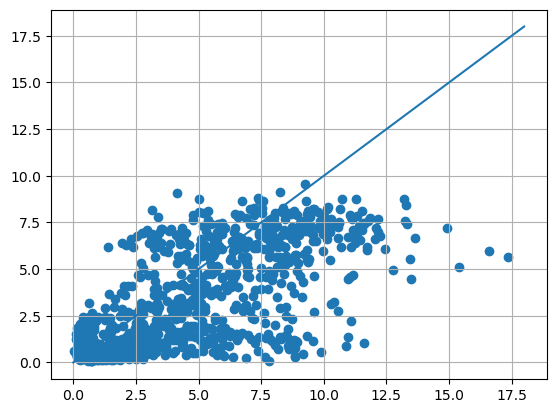

In [6]:
import matplotlib.pyplot as plt
plt.scatter(daily_pnts['ET_fill'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()


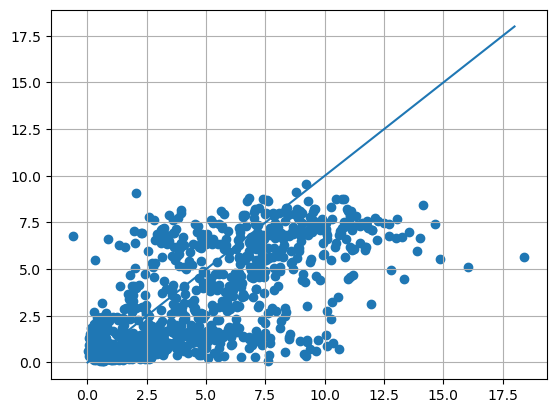

In [7]:
plt.scatter(daily_pnts['ET_corr'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

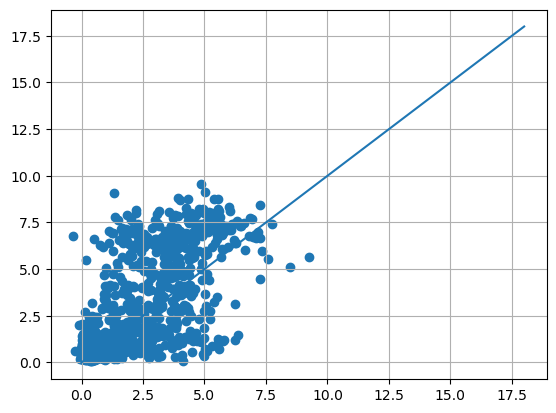

In [8]:
plt.scatter(daily_pnts['ET'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

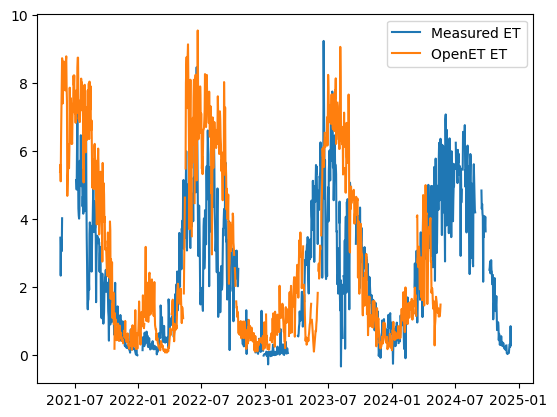

In [10]:
plt.plot(daily_pnts.index,daily_pnts['ET'],label='Measured ET')
plt.plot(daily_pnts.index,daily_pnts['openet_ens_mm'],label='OpenET ET')
plt.legend()

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

def generate_density_raster(
    gdf,
    resolution=50,  # Cell size in meters
    buffer_distance=200,  # Buffer beyond extent in meters
    epsg=5070  # Default coordinate system
):
    """
    Generate a density raster from a point GeoDataFrame, weighted by the ET field.

    Parameters:
        gdf (GeoDataFrame): Input point GeoDataFrame with an 'ET' field.
        resolution (float): Raster cell size in meters (default: 50m).
        buffer_distance (float): Buffer beyond point extent (default: 200m).
        epsg (int): Coordinate system EPSG code (default: 5070).

    Returns:
        raster (numpy.ndarray): Normalized density raster.
        transform (Affine): Affine transformation for georeferencing.
        bounds (tuple): (xmin, ymin, xmax, ymax) of the raster extent.
    """

    # Ensure correct CRS
    gdf = gdf.to_crs(epsg=epsg)

    # Extract point coordinates and ET values
    x = gdf.geometry.x
    y = gdf.geometry.y
    weights = gdf["ET"].values

    # Define raster extent with buffer
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, xmax = xmin - buffer_distance, xmax + buffer_distance
    ymin, ymax = ymin - buffer_distance, ymax + buffer_distance

    # Create a mesh grid
    xgrid = np.arange(xmin, xmax, resolution)
    ygrid = np.arange(ymin, ymax, resolution)
    xmesh, ymesh = np.meshgrid(xgrid, ygrid)

    # Perform KDE with weights
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)
    density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

    # Normalize to ensure sum of cell values is 1
    density /= np.sum(density)

    # Define raster transform
    transform = from_origin(xmin, ymax, resolution, resolution)

    return density, transform, (xmin, ymin, xmax, ymax)

# Example usage:
# gdf = gpd.read_file("points.shp")
# density_raster, transform, bounds = generate_density_raster(gdf)


In [ ]:
url = "https://services1.arcgis.com/99lidPhWCzftIe9K/arcgis/rest/services/WaterRelatedLandUse/FeatureServer/0/query?where=1%3D1&outFields=*&geometry=-110.75%2C39.438%2C-110.710%2C39.45&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=5070&f=json"

well_fields = gpd.read_file(url)
well_fields = well_fields[well_fields['OBJECTID'].isin([53384,57425])]
well_fields.plot()

In [ ]:
# Get the extent of the shapefile
total_bounds = well_fields.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 20
while y <= maxY:
    while x <= maxX:
        geom = shapely.geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:5070')
#fishnet.to_file('fishnet_grid.shp')

In [ ]:


# Create a geometry column
df['geometry'] = gpd.points_from_xy(df['X_FETCH_55'], df['Y_FETCH_55'])
df['geometry'].unique()
# Convert the DataFrame to a GeoDataFrame
#gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
df